# Data Analytics Fall 2025 &mdash; Exercises 4

### XXXXX XXXXX (last modified: Sat 25 Oct &mdash; problem 4 data clarification)

- Five problems + round 3 peer review
- Deadline: Tue Nov 4 (Teams session)
- Theme: time series
- Keep your originals up to date by running the code cell below:

In [ ]:
import os
os.system('/usr/bin/bash /home/varpha/dan/config.sh');

## Plan for calendar week 43

- overview on Tuesday (Teams)
- deeper during the weekend (face-to-face).

No Teams session on Tue Oct 28 (after the weekend).


## Round 3 peer review

As before. Please ask on the channel or by email if you have issues.

## Problem 1. Shifting
The file

    public/exrc_04/data/windmill_temperature.csv
  
contains a temperature timeseries measured from the top of a windmill at about 200 meters high.

The file

    public/exrc_04/data/fmi_temperature.csv
    
contains the corresponding [fmi](en.ilmatieteenlaitos.fi) temperature timeseries measured from a nearby station at 2 meters high, and about 30km away from the windmill.

The windmill operator did not include any metadata, e.g. what is the timezone in the windmill data. Your task is to find out what is the difference (if any) in the timezones.

**Note: This is not an easy task, and there is not a best method (unless we agree having found one)!**

## Use of AI in this exercise
I leveraged AI tools to:
- Learn new concepts related to tasks
- Brainstorm solutions
- Generate and adapt sample code to solve the problems in different ways

## Solution 1

As per below solution Windmill data is 2 hours ahead for FMI data hence Windmill data is in EET timezone (ie UTC + 2).

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from getpass import getuser

user = getuser()
csv_location_windmill = f'/home/{user}/dan/public/exrc_04/data/windmill_temperature.csv'
csv_location_fmi = f'/home/{user}/dan/public/exrc_04/data/fmi_temperature.csv'

#csv_location_windmill = "FILE_NAME" ### GIVE FILE_NAME FOR WINDMILL TO RUN THE CODE LOCALLY ON YOUR MACHINE
#csv_location_fmi = "FILE_NAME" ### GIVE FILE_NAME FOR FMI TO RUN THE CODE LOCALLY ON YOUR MACHINE

# load the input csv files into pandas dataframe
df_windmill = pd.read_csv(csv_location_windmill)
df_fmi = pd.read_csv(csv_location_fmi)

# # Lets describe and check the data and properties of both the dataframes
# print(df_windmill.info())  # prints concise summary about DataFrame's structure
# print(df_windmill.head())  # prints first five rows - default

# print(df_fmi.info())  # prints concise summary about DataFrame's structure
# print(df_fmi.head())  # prints first five rows - default

# In df_windmill: Reformat the column ´t´ to proper date format for comparison and then set it as a index
df_windmill['t'] = pd.to_datetime(df_windmill['t'], format="%Y %m %d %H:%M:%S")
df_windmill = df_windmill.set_index('t')

# print(df_windmill.head()) # print sample data

# In df_fmi: Create new column ´datetime_str´ by using existing date and time related columns and set it as a index
df_fmi['datetime_str'] = (
    df_fmi['Year'].astype(str) + ' ' +
    df_fmi['Month'].astype(str).str.zfill(2) + ' ' +
    df_fmi['Day'].astype(str).str.zfill(2) + ' ' +
    df_fmi['Time'].astype(str) + ':00' # add seconds to match format with df_windmill['t']
)
df_fmi['datetime'] = pd.to_datetime(df_fmi['datetime_str'], format="%Y %m %d %H:%M:%S")
df_fmi = df_fmi.set_index('datetime')
# print(df_fmi.head()) # print sample data

# Drop not required cloumns from df_fmi dataframe
df_fmi.drop(columns=["Year", "Month", "Day", "Time", "Timezone", "datetime_str"],inplace=True)
# print(df_fmi.head()) # print sample data

# # Check data types for both dataframes before doing resampling with mean() function
# print(df_windmill.dtypes)
# print(df_fmi.dtypes)

# Convert Temperature(degC) to numeric on df_fmi
df_fmi['Temperature(degC)'] = pd.to_numeric(df_fmi['Temperature(degC)'], errors='coerce')
# print(df_windmill.dtypes) # for verification
# print(df_fmi.dtypes) # for verification

# Resample both dataframes with 1h interval to easier comparison
df_windmill_hourly = df_windmill.resample('1h').mean()
df_fmi_hourly = df_fmi.resample('1h').mean()

# print(df_windmill_hourly.head()) # print sample data
# print(df_fmi_hourly.head()) # print sample data

# Cobine the two hours dataseries df_windmill_hourly and df_fmi_hourly
df_combined = pd.DataFrame({
    'windmill': df_windmill_hourly['T_NacOutAir.actual'],
    'fmi': df_fmi_hourly['Temperature(degC)']
}).dropna() # remove the rows where any of the column has NaN

# print(df_combined.head()) # print sample data

results = []

# Loop over possible timezone shifts (±5 hours)
for shift in range(-5, 6):
    corr = df_combined['windmill'].shift(shift).corr(df_combined['fmi'])
    results.append((shift, corr))

# Put results into a DataFrame for easy analysis
df_corr = pd.DataFrame(results, columns=['shift_hours', 'correlation'])
# print(df_corr.head())

# Analyse the correlations and find the highest correlation
best_shift = df_corr.loc[df_corr['correlation'].idxmax(), 'shift_hours']
best_corr = df_corr['correlation'].max()

if best_shift > 0:
    relation = f"Windmill data is {abs(best_shift)} hours behind FMI"
elif best_shift < 0:
    relation = f"Windmill data is {abs(best_shift)} hours ahead of FMI"
else:
    relation = "Windmill and FMI timestamps are already aligned (no timezone difference)."

print(f"Best timezone offset: {best_shift:+} hours (correlation={best_corr:.3f}) — {relation}")


Best timezone offset: -2 hours (correlation=0.956) — Windmill data is 2 hours ahead of FMI


## Problem 2. Worktimes
The file

    public/exrc_04/data/harri_worktimes.json
    
contains Harri's [taskwarrior](https://taskwarrior.org) data from fall 2024. The file

    public/exrc_04/data/harri_worktimes_metadata.txt

contains explanations of the tags etc.

What has Harri worked on and how many hours? Just wrangle the timestamps and group by the tags. That's the minimum requirement for the point! Then something graphical would be nice too. (The timestamps are in GMT, i.e. three hours off from EEST, but that is irrelevant for the exercise.)

## Solution 2

I have solved the problem in two ways which I refered as Version 1 and Version 2.

**Version 1:** Where hours / effort is not divided between individual tag. Ex lets say 1 hr is the effort for tags [a, b] then its considered 1 hr for each tag

**Version 2:** Where hours / effort is divided between indvidual tags equally ie data is normalised. Ex lets say 1 hr is the effort for tags [a, b] then its considered .5 hr for each tag


***************************** Version 1: Hours by Tag ***********************************
                                                                 tags      hours
                                                                  ttv 191.715556
                                                                  dan 136.356389
                                                                  tic 107.977778
                                                        dan: planning 101.788889
                                                   discrete: planning  63.947222
                                                        communication  38.046111
                                                discrete: teaching fi  26.873889
                                                                  yfs  18.031389
                                         vanhaa valintakoetta pystyyn  16.216667
                                                        dan: teaching  10.186944
                  

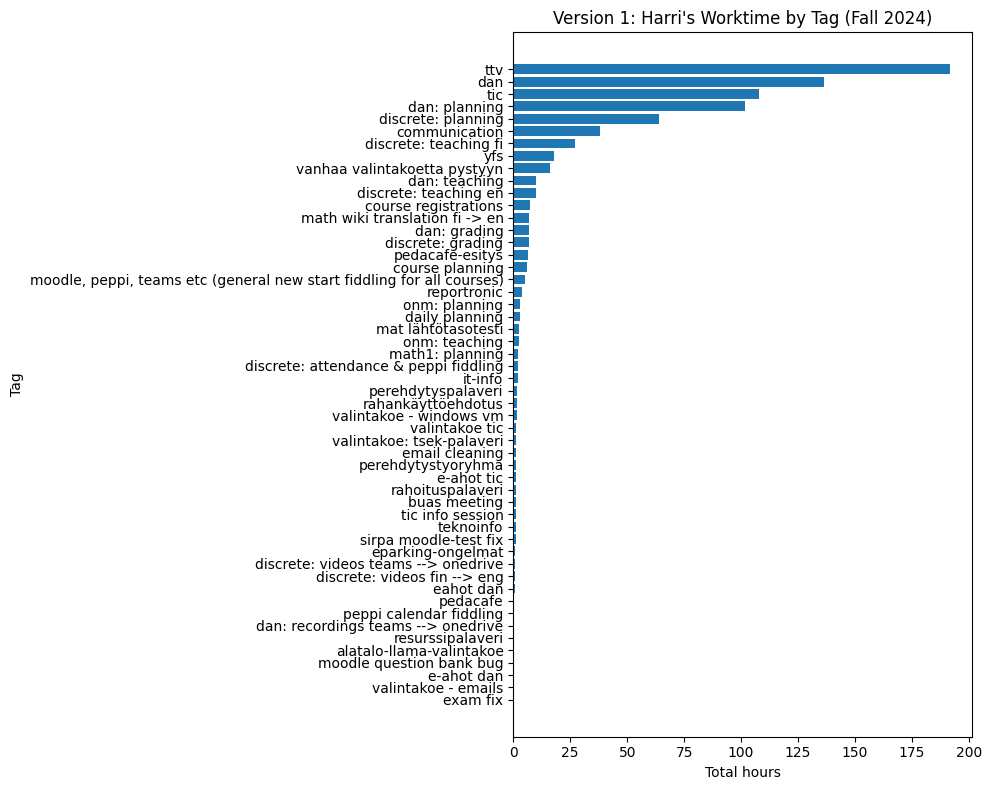

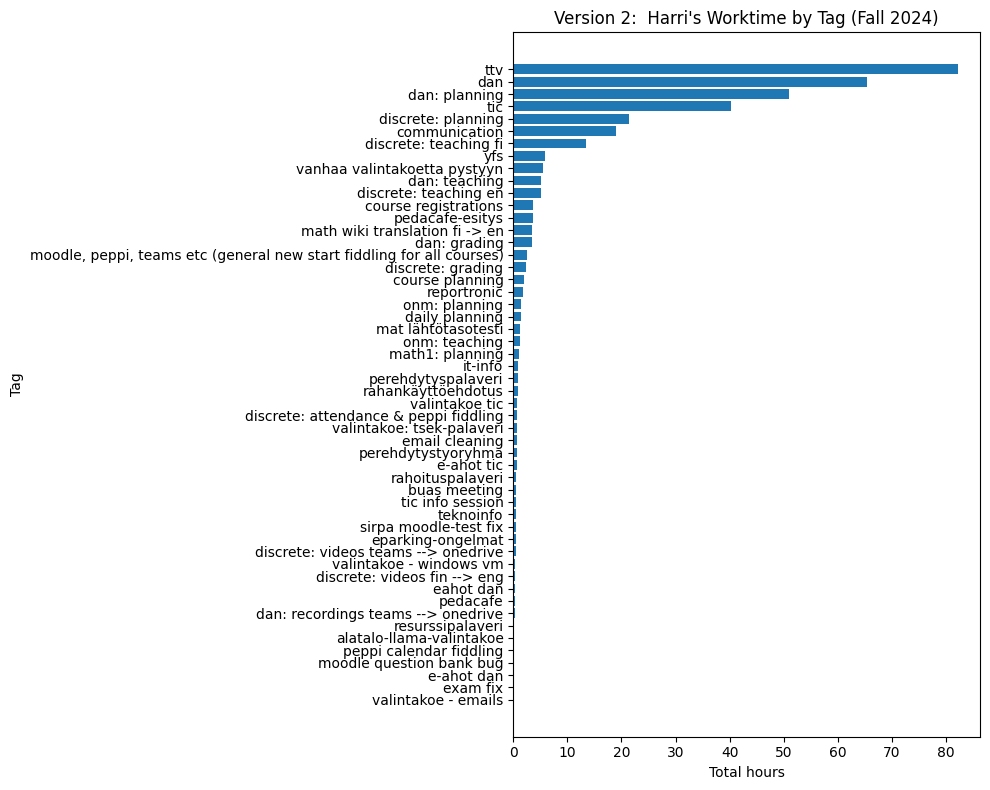

In [12]:
from getpass import getuser
import pandas as pd
import matplotlib.pyplot as plt

user = getuser()
json_location = f'/home/{user}/dan/public/exrc_04/data/harri_worktimes.json'
# json_location =  "FILE_NAME" ### GIVE FILE_NAME TO RUN THE CODE LOCALLY

# Load input JSON data which contains Harri's worktimes data from fall 2024
df = pd.read_json(json_location)

# # Lets describe and check the data and properties of dataframe
# print(df.info())  # prints concise summary about DataFrame's structure
# print(df.columns) # prints information about columns
# print(df.head())  # prints first five rows - default

# Convert the start and end column datatypes to datetime type with proper readable date format which can used to calculate hours
df["start"] = pd.to_datetime(df["start"], format="%Y%m%dT%H%M%SZ")
df["end"]   = pd.to_datetime(df["end"],   format="%Y%m%dT%H%M%SZ")

# Create a new column ´hours´ by using ´start´ and ´end' columns
df["hours"] = (df["end"] - df["start"]).dt.total_seconds() / 3600.0

# print(df.head()) # check the sample data

# Version 1: Here explode the data without dividing the hours at tag level ie doubling the hours
# Mean while exploding the ´tags´ column each tag get the same effort from ´hours´ column 

# Create separate entry for each tag value present in ´tags´ column using ´explode´ method
df_extend_ver1 = df.explode("tags")

# print(df_extend_ver1.head()) # check the sample data
# df_extend_ver1.to_csv("df_extend_ver1.csv", index=False) # create a file for validation


# Perform groupby at ´tags´ to get the sum of ´hours´ coloumn
df_extend_group_by_tag_ver1 = (
    df_extend_ver1.groupby("tags")["hours"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

print("\n***************************** Version 1: Hours by Tag ***********************************")
print(df_extend_group_by_tag_ver1.to_string(index=False))

# Version1: Plot a Horizontal Bar Chart
plt.figure(figsize=(10, 8))
plt.barh(df_extend_group_by_tag_ver1["tags"], df_extend_group_by_tag_ver1["hours"])
plt.xlabel("Total hours")
plt.ylabel("Tag")
plt.title("Version 1: Harri's Worktime by Tag (Fall 2024)")
plt.gca().invert_yaxis() #flips the order of bars vertically so the largest values appear at the top instead of the bottom
plt.tight_layout()



# Version 2: Here explode the data post normalising the hours per tag
# Mean first calculate the hours per tags by then explode the data

# Create new column ´hours_per_tag´ to divide the effort at tag level
df["hours_per_tag"] = df["hours"] / df["tags"].apply(len)

# Create separate entry for each tag value present in ´tags´ column using ´explode´ method
df_extend_ver2 = df.explode("tags")

# print(df_extend_ver2.head()) # check the sample data
# df_extend_ver2.to_csv("df_extend_ver2.csv", index=False) # create a file for validation

# Perform groupby at ´tags´ to get the sum of ´hours_per_tag´ coloumn
df_extend_group_by_tag_ver2 = (
    df_extend_ver2.groupby("tags")["hours_per_tag"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

print("\n***************************** Version 2: Hours by Tag ***********************************")
print(df_extend_group_by_tag_ver2.to_string(index=False))

# Version 2: Plot a Horizontal Bar Chart
plt.figure(figsize=(10, 8))
plt.barh(df_extend_group_by_tag_ver2["tags"], df_extend_group_by_tag_ver2["hours_per_tag"])
plt.xlabel("Total hours")
plt.ylabel("Tag")
plt.title("Version 2:  Harri's Worktime by Tag (Fall 2024)")
plt.gca().invert_yaxis()
plt.tight_layout()

## Problem 3. Sales

(Most of this problem may already be done for you in the theory notes.)

The file

    private/exrc_04/data/XXXXX_prob3_sales.csv

contains some (fake) daily sales data.

Please perform the following basic wranglings:

- convert the date column to a standard datetime type (there may be several ways to do that)
- index the dataframe by the date column
- in the theory notes we used the **rolling** function but **let's forget about that**
- using **resample** and **sum**, downsample the data from daily to a monthly frequency
- shift the resampled data by one month to reflect the previous month's sales (i.e. your last "monthly sales report" should happen at March 2023 and be about Feb 2023)
- plot a sales curve and calculate some descriptive statistics (feel free to do what you want here, doesn't need to be anything fancy).


## Solution 3

Descriptive statistics of shifted monthly sales:
count        13.000000
mean     171353.307692
std       15768.294990
min      150620.000000
25%      155278.000000
50%      174406.000000
75%      181792.000000
max      200418.000000
Name: sales, dtype: float64


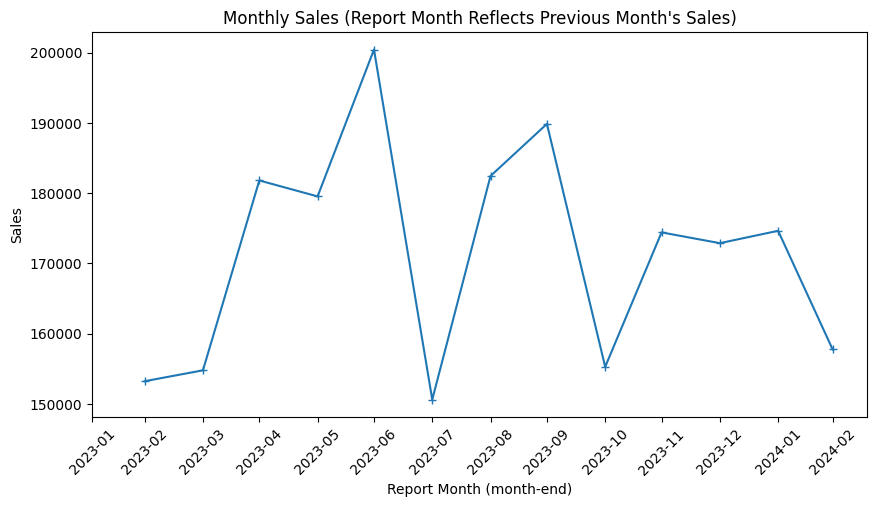

In [14]:
from getpass import getuser
import pandas as pd
import matplotlib.pyplot as plt

user = getuser()
csv_location = f'/home/{user}/dan/private/exrc_04/data/{user}_prob3_sales.csv'

# csv_location =  "FILE_NAME" ### GIVE FILE_NAME TO RUN THE CODE LOCALLY ON YOUR MACHINE

# Load input CSV data which contains some (fake) daily sales data
df = pd.read_csv(csv_location)

# # Lets describe and check the data and properties of dataframe
# print(df.info())  # prints concise summary about DataFrame's structure
# print(df.columns) # prints information about columns
# print(df.head())  # prints first five rows - default

# Extract ´sales´ and ´date´ columns only which are needed
df = df[["date", "sales"]]

# # Check the columns again)
# print(df.columns)

# Convert data type of date column currently its object datatype
df['date'] = pd.to_datetime(df['date'])

# print(df.info()) # check the data types for columns again

# index the dataframe by the´date' column
df = df.set_index('date')
# print(df.head())

# using **resample** and **sum**, downsample the data from daily to a monthly frequency
df_monthly_sales = df.resample('ME').sum() # Aggregates the sales upto end of each month
# print(df_monthly_sales.head())

# Shift the resampled data by one month to reflect the previous month's sales usig ´shift()´ method
df_monthly_sales_shifted = df_monthly_sales.shift(1)
# print(df_monthly_sales_shifted.head())
# print(df_monthly_sales_shifted.to_string()) # to print the whole dataframe

# Descriptive statistics on the shifted monthly sales column
stats = df_monthly_sales_shifted['sales'].describe()
print("Descriptive statistics of shifted monthly sales:")
print(stats)

# Plot a sales curve using matplotlib
plt.figure(figsize=(10, 5))
plt.plot(df_monthly_sales_shifted.index, df_monthly_sales_shifted['sales'], marker='+')
plt.title("Monthly Sales (Report Month Reflects Previous Month's Sales)")
plt.xlabel("Report Month (month-end)")
plt.ylabel("Sales")

# Force month labels for every tick / marker for better visibilty of month value on x axis
plt.xticks(df_monthly_sales_shifted.index, df_monthly_sales_shifted.index.strftime('%Y-%m'), rotation=45)

plt.show() 

## Problem 4. Weather
The file

    public/exrc_04/data/prob4_weather.csv
   
contains some hourly temperature forecast data for Jyväskylä (2022-2023), downloaded from the Norwegian meterological institute.

Train a seasonal arima model using this data, then make a Jyväskylä hourly temperature forecast for the next day after the training data ends.

How was the forecast? What were the arima parameters that were used in the model?

You may either mimic the champagne blog or use sktime.

**Please note:** The data is probably bad in that it's too short; no clear yearly seasonality for example. So no good results are expected. But that's not the point! Instead, the point is to fit a "difficult" model to a data that is not toy data.


## Solution 4

Forecast looks good and somehow close to training data range. Since there were no real data for next day after the training data ends to compare with. One way could be splitting the input data into training and test data but it was not asked hence did not perform that extra step.

The model used for forecasting Jyväskylä’s hourly temperature data was a **Seasonal ARIMA (SARIMA)** model with the following parameters:

order=(1,1,1)  
seasonal_order=(1,1,1,24)  
enforce_stationarity=False  
enforce_invertibility=False


**Explanation:**
- The `(1,1,1)` part captures **short-term patterns and trends**.  
- The `(1,1,1,24)` seasonal component captures the **repeating daily temperature cycle** in the hourly data.
- `enforce_stationarity=False` Allows the model to handle real-world data that isn’t perfectly stable over time (like gradual temperature changes).
- `enforce_invertibility=False` Gives the model more flexibility to find the best fit, even if it slightly breaks strict mathematical rules.
- Together, these parameters allow the model to represent both **local fluctuations** and **daily seasonality** effectively.

In [19]:
from getpass import getuser
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

user = getuser()
csv_location = f'/home/{user}/dan/public/exrc_04/data/prob4_weather.csv'

# csv_location =  "FILE_NAME" ### GIVE FILE_NAME TO RUN THE CODE LOCALLY ON YOUR MACHINE

# Load input CSV data which contains some hourly temperature forecast data for Jyväskylä (2022-2023)
df_weather = pd.read_csv(csv_location)

# # Lets describe and check the data and properties of dataframe
# print(df_weather.info())  # prints concise summary about DataFrame's structure
# print(df_weather.columns) # prints information about columns
# print(df_weather.head())  # prints first five rows - default

# Convert the ´time´ column to datetime objects
df_weather['datetime'] = pd.to_datetime(df_weather['time'], unit='s', utc=True)
df_weather.to_csv("df_weather.csv", index=False) # create a file for validatiom

# 3. Set the 'datetime' column as the index
df_weather = df_weather.set_index('datetime')

# Drop the original 'time' column if no longer needed
df_weather = df_weather.drop('time', axis=1)

# print(df_weather.head()) # print sample data

# Keep only the temperature column for modeling
y = df_weather['air_temperature_2m']
# print(y.head()) # print sample data

# Reindex to ensure a perfect hourly sequence (fills any missing hours)
y = y.asfreq('h')

# # Confirm if there any any NaN entry
# print(y.info()) 
# print(y.isna().sum()) # Ouput is 0 means there is NaN entries

# Train the Seasonal Arima model using the input data
model = SARIMAX(y,
                order=(1,1,1),
                seasonal_order=(1,1,1,24),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)

# Forecast the next 24 hours beyond the dataset where last entry is for 2023-03-12 23:00:00+00:00
forecast = results.forecast(steps=24)
print("\nPrint Jyväskylä hourly temperature forecast for the next day")
print(forecast)




Print Jyväskylä hourly temperature forecast for the next day
2023-03-13 00:00:00+00:00    263.372563
2023-03-13 01:00:00+00:00    263.314631
2023-03-13 02:00:00+00:00    263.007888
2023-03-13 03:00:00+00:00    262.807294
2023-03-13 04:00:00+00:00    262.732609
2023-03-13 05:00:00+00:00    262.687094
2023-03-13 06:00:00+00:00    262.804432
2023-03-13 07:00:00+00:00    263.525073
2023-03-13 08:00:00+00:00    264.554074
2023-03-13 09:00:00+00:00    265.616893
2023-03-13 10:00:00+00:00    266.590394
2023-03-13 11:00:00+00:00    267.445305
2023-03-13 12:00:00+00:00    267.962948
2023-03-13 13:00:00+00:00    268.140027
2023-03-13 14:00:00+00:00    267.920631
2023-03-13 15:00:00+00:00    267.365878
2023-03-13 16:00:00+00:00    266.449610
2023-03-13 17:00:00+00:00    265.586047
2023-03-13 18:00:00+00:00    264.981118
2023-03-13 19:00:00+00:00    264.648413
2023-03-13 20:00:00+00:00    264.226467
2023-03-13 21:00:00+00:00    263.881927
2023-03-13 22:00:00+00:00    263.646717
2023-03-13 23:00:0

## Problem 5. Blog study

Study [this notebook](https://github.com/jahangirmammadov/sarima/blob/master/Seasonal%20Time%20Series%20Analysis.ipynb). Then download a different data from [this site](https://fred.stlouisfed.org/categories). (The site is kind of random & chosen only because it occurred in the notebook.) *Please try to obtain unique data for yourself* (maybe from a better site), i.e. please discuss on your Discord channel (or whatever) in order to avoid having the same data for two different persons. Apply the methods in the blog, and write a report about how it went. What questions would you like to understand better? **Note:** Pandas version 1 (old) is used in the notebook; there is at least one syntax that needs to be replaced.


## Solution 5
# Reflection on SARIMA Notebook and DEXINUS Time Series Analysis

I studied the notebook *Seasonal Time Series Analysis* from the provided GitHub link. The notebook introduces key time-series concepts such as trend, seasonality, stationarity, autocorrelation, and SARIMA modeling using a time series dataset.

Since the assignment required using a different dataset, I searched the FRED database and downloaded the **DEXINUS** series, which represents the *Daily Indian Rupees to U.S. Dollar Spot Exchange Rate*. I specifically selected the **non-seasonally adjusted** version, because SARIMA models are designed to learn and model seasonality directly from raw data; using seasonally-adjusted data would remove information that SARIMA is supposed to capture.

---

## Steps I Applied from the Notebook

After loading the DEXINUS data, I applied the parts of the notebook that I understood well. This included:

- Cleaning the dataset  
- Converting the date column to a datetime index  
- Checking and handling missing values  
- Plotting the time series  
- Computing and visualizing ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function)  
- Examining the distribution of the data  

These steps helped me understand the overall structure of the exchange-rate time series:
- whether there are long-term trends,  
- how strongly the series depends on past values, and  
- whether any repeating seasonal patterns are present.

---

## Where I Struggled

I started to struggle in the later parts of the notebook, especially with:

- **Seasonal decomposition**
- Interpretation of the **trend**, **seasonal**, and **residual** components
- Connecting these decomposed components to SARIMA parameter choices

Unlike datasets such as hourly temperatures or monthly consumption, foreign exchange rates do not exhibit strong or obvious seasonal cycles. This made it difficult to interpret the seasonal decomposition plots, because the seasonal component appeared very weak or unclear. I also found it challenging to understand how exactly those plots should guide the choice of seasonal ARIMA parameters.

Overall, I was able to reproduce the earlier exploratory steps from the notebook and understand how to:

- check for stationarity,
- examine autocorrelation structures, and
- prepare data for modeling.

However, the deeper conceptual details about seasonal components, selecting seasonal parameters, and interpreting SARIMA outputs remain areas where I still feel unsure.

---

## Questions I Would Like to Understand Better

1. **How do we identify seasonality when the time series does not have obvious seasonal patterns (like financial data)?**  
2. **When is seasonal differencing necessary, and how do we detect it reliably?**  
3. **How exactly do the seasonal AR (P) and MA (Q) terms in SARIMA affect the model?**  
4. **How should I interpret the trend, seasonal, and residual components produced by seasonal decomposition?**  
5. **What are the best practices for choosing SARIMA parameters when the ACF/PACF plots are not strongly indicative?**

These are the main areas I would like to study further to gain more confidence in applying SARIMA models effectively.


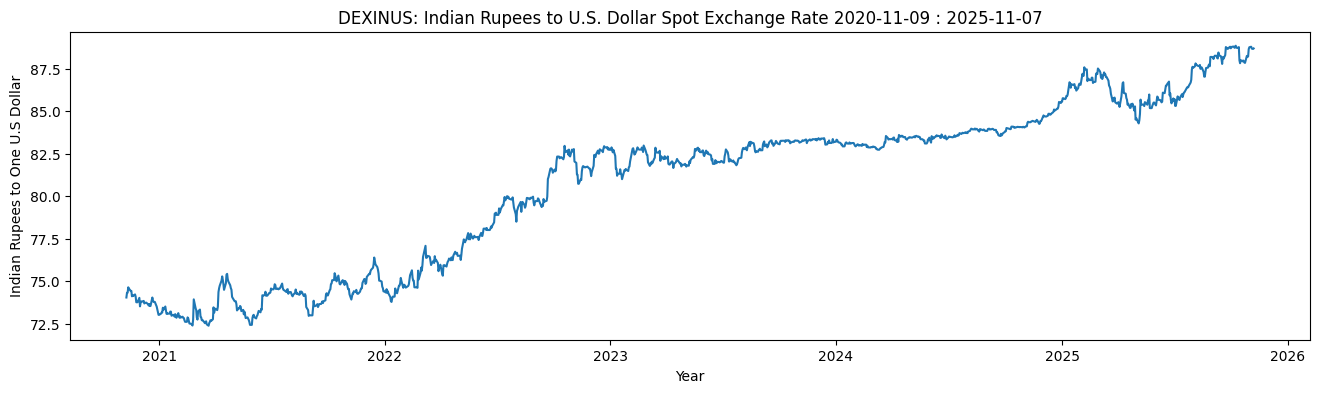

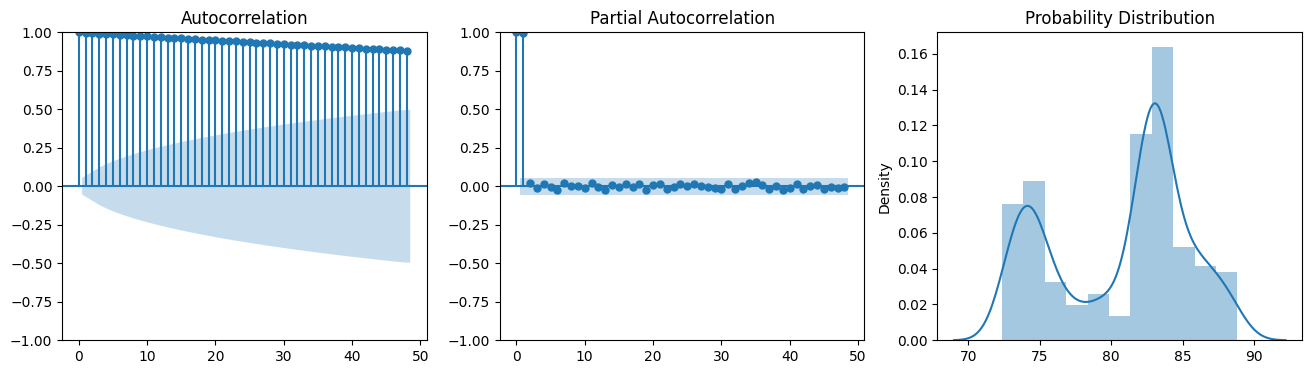

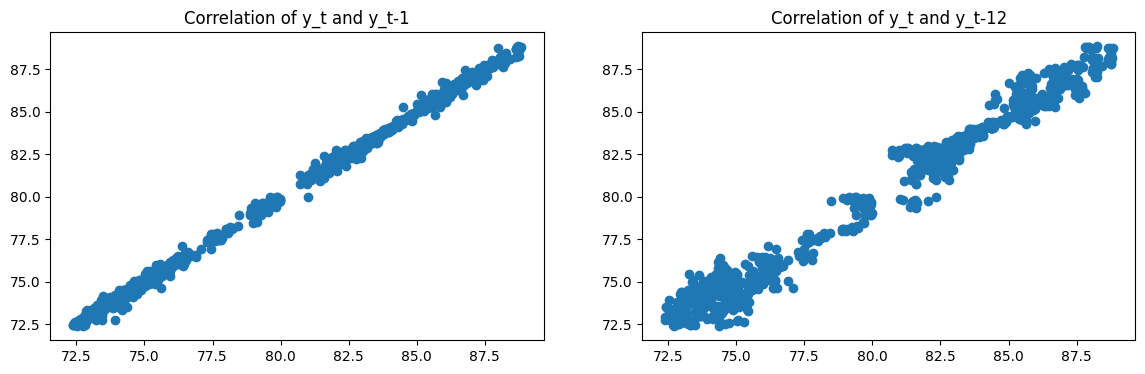

Time series data is not stationary. Adfuller test pvalue=0.8940273042063972


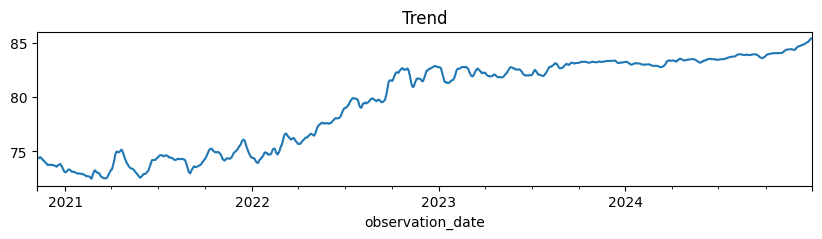

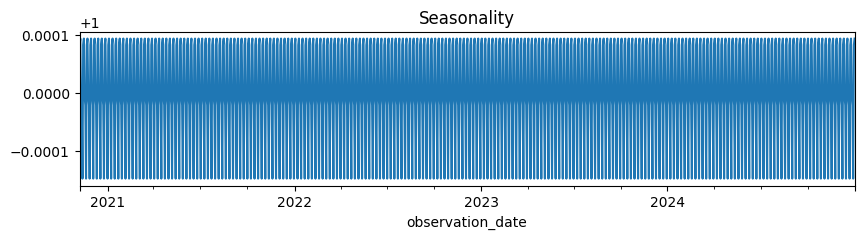

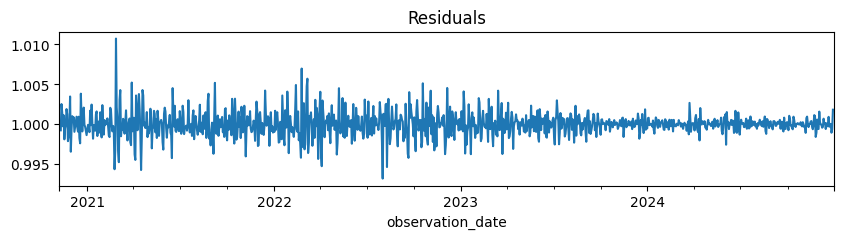

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

csv_location = "DEXINUS.csv"

# Load input CSV data, set ´observation_date´ col as index and convert it to datetime
df = pd.read_csv(csv_location, index_col='observation_date', parse_dates=True)

# # Lets describe and check the data and properties of dataframe
# print("Datatype for index is", type(df.index)) # wanted to confirm parse_dates=True option
# print(df.info())  # prints concise summary about DataFrame's structure
# print(df.head())  # prints first five rows - default

# Check if there is NaN entries
# print(df.isna().sum()) # There are NaN entries which is expected due to Holidays and Weekends

# Fill those NaN using ffill() since On weekends/holidays the rate simply remains the last known spot rate
df['DEXINUS'] = df['DEXINUS'].ffill()
# print(df.isna().sum()) # prins 0 means no NaN value

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

def plot_data_properties(data, ts_plot_name="Time Series plot"):
    '''
    Summary:
    -------
    Plots various plots, including time series, autocorrelation,
    partial autocorrelation and distribution plots of data.
    
    Parameters:
    ----------
    ts_plot_name(String): The name of the time series plot
    data(pd.Dataframe, pd.Series, array): Time Series Data
    
    Returns:
    --------
    None
    
    '''
    plt.figure(figsize=(16,4))
    plt.plot(data)
    plt.title(ts_plot_name)
    plt.ylabel('Indian Rupees to One U.S Dollar')
    plt.xlabel('Year')
    fig, axes = plt.subplots(1,3,squeeze=False)
    fig.set_size_inches(16,4)
    plot_acf(data, ax=axes[0,0], lags=48)
    plot_pacf(data, ax=axes[0,1], lags=48)
    sns.distplot(data, ax=axes[0,2])
    axes[0,2].set_title("Probability Distribution")

plot_data_properties(df, 'DEXINUS: Indian Rupees to U.S. Dollar Spot Exchange Rate 2020-11-09 : 2025-11-07')

fig, axes = plt.subplots(1,2, squeeze=False)
fig.set_size_inches(14,4)
axes[0,0].scatter(x=df[1:], y=df.shift(1)[1:])
axes[0,1].scatter(x=df[12:], y=df.shift(12)[12:])
axes[0,0].set_title('Correlation of y_t and y_t-1')
axes[0,1].set_title('Correlation of y_t and y_t-12')
plt.show()

from statsmodels.tsa.stattools import adfuller
def test_stationarity(data):
    '''
    Summary:
    -------
    Performs Adfuller test on given time series data to test stationarity.
    p_val >= 0.05 means the data is not stationary, otherwise (p_val < 0.05) it is stationary.
    
    Parameters:
    data(pd.Dataframe, pd.Series. np.array): Time series data to be tested
    
    Return:
    ------
    '''
    p_val=adfuller(data['DEXINUS'])[1]
    if p_val >= 0.05:
        print("Time series data is not stationary. Adfuller test pvalue={}".format(p_val))
    else:
        print("Time series data is stationary. Adfuller test pvalue={}".format(p_val))

test_stationarity(df)


# Spilt the data to training and test data
# Training data will contain rows from the beginning of the dataset up to 2024-12-31 (inclusive)
# Test data will have all rows from 2025-01-01 to the end of the input data
training_data = df.loc[:'2024-12-31']
test_data = df.loc['2025-01-01':]

def plot_seasonal_decompose(data, model):
    '''
    Summary:
    -------
    Plots trend, seasonality and residuals with bigger plot size=(10,2)
    
    Parameters:
    ----------
    data(pd.Dataframe, pd.Series): time series data
    
    Return:
    ------
    decomposition(obj): return value of statsmodels.tsa.seasonal.seasonal_decompose
    '''
    decomposition = seasonal_decompose(data,model=model)
    decomposition.trend.plot(figsize=(10,2), title='Trend')
    plt.show()
    decomposition.seasonal.plot(figsize=(10,2), title='Seasonality')
    plt.show()
    decomposition.resid.plot(figsize=(10,2), title='Residuals')
    plt.show()
    return decomposition

decomposition = plot_seasonal_decompose(training_data, 'multiplicative')